## Data Science Final Project : Poster Prediction
### Group Members : Jiachang Shi, Boyuan Sun, Xiangru Shu

### Notebook introduction
this notebook documents the poster preprocessing and convolutional neural network structure on posters to predict the genre type. The ultimate goal is to train a neural network that can classify the type of genre based on the posters only. However, we have found that the compressed and reshaped posters do not provide insightful information on the genre of a movie.

### Library Used

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
sns.set()
import ast
#from tqdm import tqdm
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, RepeatVector, Reshape
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from random import shuffle
from sklearn import metrics
from meter import *
%matplotlib inline

### Image Classification to Genres

In [2]:
imdb_movie = pd.read_csv('data/imdb_multilabel.csv', index_col = 0)

FileNotFoundError: File b'data/imdb_multilabel.csv' does not exist

In [3]:
imdb_movie.head()

,title,imdb_id,topRank,bottomRank,metaScore,plot,rating,ratingCount,reviewCount,runningTimeInMinutes,userRatingCount,userScore,year,all_genre,genre,plot_list,genreCount,genre_code,all_genre_encode
0,"I, Tonya",tt5580036,930.0,17643.0,77.0,From the proverbial wrong side of the tracks i...,7.6,67667.0,46,120.0,235,7.8,2017.0,"['Biography', 'Comedy', 'Drama', 'Sport']",sport,"['From', 'the', 'proverbial', 'wrong', 'side',...",4,0,[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1,Cars 3,tt3606752,2256.0,11547.0,59.0,Blindsided by a new generation of blazing-fast...,6.8,41896.0,41,102.0,232,6.9,2017.0,"['Animation', 'Adventure', 'Comedy', 'Family',...",sport,"['Blindsided', 'by', 'a', 'new', 'generation',...",5,0,[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. ...
2,Creed,tt3076658,847.0,17840.0,82.0,Adonis Johnson is the son of the famous boxing...,7.6,193206.0,42,133.0,614,8.0,2015.0,"['Drama', 'Sport']",sport,"['Adonis', 'Johnson', 'is', 'the', 'son', 'of'...",2,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3,Battle of the Sexes,tt4622512,2303.0,11228.0,73.0,In the wake of the sexual revolution and the r...,6.8,27960.0,46,121.0,102,6.3,2017.0,"['Biography', 'Comedy', 'Drama', 'Sport']",sport,"['In', 'the', 'wake', 'of', 'the', 'sexual', '...",4,0,[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4,Borg McEnroe,tt5727282,NaN,12891.0,57.0,The story of the 1980s tennis rivalry between ...,7.0,9800.0,13,107.0,0,NaN,2017.0,"['Biography', 'Drama', 'Sport']",sport,"['The', 'story', 'of', 'the', '1980s', 'tennis...",3,0,[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


#### encode the genre as a single-label array and a multi-label array

#### single-label encode

In [4]:
genre_dict = dict(zip(imdb_movie.genre.unique(), range(20)))
genre_dict['sci-fi'] = 8
imdb_movie['genre_code'] = imdb_movie.genre.replace(genre_dict).values

In [5]:
imdb_movie.head()

,title,imdb_id,topRank,bottomRank,metaScore,plot,rating,ratingCount,reviewCount,runningTimeInMinutes,userRatingCount,userScore,year,all_genre,genre,plot_list,genreCount,genre_code,all_genre_encode
0,"I, Tonya",tt5580036,930.0,17643.0,77.0,From the proverbial wrong side of the tracks i...,7.6,67667.0,46,120.0,235,7.8,2017.0,"['Biography', 'Comedy', 'Drama', 'Sport']",sport,"['From', 'the', 'proverbial', 'wrong', 'side',...",4,0,[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1,Cars 3,tt3606752,2256.0,11547.0,59.0,Blindsided by a new generation of blazing-fast...,6.8,41896.0,41,102.0,232,6.9,2017.0,"['Animation', 'Adventure', 'Comedy', 'Family',...",sport,"['Blindsided', 'by', 'a', 'new', 'generation',...",5,0,[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. ...
2,Creed,tt3076658,847.0,17840.0,82.0,Adonis Johnson is the son of the famous boxing...,7.6,193206.0,42,133.0,614,8.0,2015.0,"['Drama', 'Sport']",sport,"['Adonis', 'Johnson', 'is', 'the', 'son', 'of'...",2,0,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3,Battle of the Sexes,tt4622512,2303.0,11228.0,73.0,In the wake of the sexual revolution and the r...,6.8,27960.0,46,121.0,102,6.3,2017.0,"['Biography', 'Comedy', 'Drama', 'Sport']",sport,"['In', 'the', 'wake', 'of', 'the', 'sexual', '...",4,0,[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4,Borg McEnroe,tt5727282,NaN,12891.0,57.0,The story of the 1980s tennis rivalry between ...,7.0,9800.0,13,107.0,0,NaN,2017.0,"['Biography', 'Drama', 'Sport']",sport,"['The', 'story', 'of', 'the', '1980s', 'tennis...",3,0,[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


#### multi-label encode as an array

In [7]:
def multi_label_encoder(all_genre_list):
    """ This function takes a list of genre with a dictionary that keeps track of the index of the genre
    INPUTS
    ------
    all_genre_list: list of genres
    genre_dict: dictionary of indexs
    
    OUTPUTS
    -------
    np array in {0, 1}
    """
    encode = np.zeros((20, 1))
    all_genre_list = ast.literal_eval(all_genre_list)
    for genre in all_genre_list:
        if genre.lower() in genre_dict:
            encode[genre_dict[genre.lower()]] = 1
    return encode

In [8]:
# imdb_movie['all_genre_encode'] = imdb_movie['all_genre'].values.apply(multi_label_encoder)
all_genre_encode = np.zeros((len(imdb_movie['all_genre']), 20))
for idx, val in enumerate(imdb_movie['all_genre'].values):
    all_genre_encode[idx] = multi_label_encoder(val).reshape((20,))
all_genre_encode

array([[1., 0., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Preprocessing the Poster Images

#### dictionary that keeps track of the poster genre index

In [9]:
poster_index = dict(zip(imdb_movie.imdb_id.values, range(len(imdb_movie.imdb_id.values))))

#### input the names of the poster and shuffle our dataset

In [10]:
import os
from scipy import ndimage, misc
poster_names = os.listdir('posters')[1:]
shuffle(poster_names)

In [11]:
target_labels = []
missing_count = 0
for poster_id in poster_names:
    poster_id = poster_id.strip('.jpg')
    if poster_id in poster_index:
        poster_id = poster_id.strip('.jpg')
        target_labels.append(all_genre_encode[poster_index[poster_id]])
    else:
        missing_count += 1

In [12]:
# target label after shuffling
target_labels = np.array(target_labels)

In [13]:
target_labels

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [14]:
target_labels.shape

(6243, 20)

In [9]:
# train size
train_size = 4000

#### train data

In [16]:
# get the train data
poster_images = []
for poster_name in tqdm(poster_names[:train_size]):
    poster_id = poster_name.strip('.jpg')
    image = plt.imread('posters/' + poster_name)
    image_resized = misc.imresize(image, (60, 30))
    if image_resized.shape == (60, 30):
        image_resized = np.array([image_resized, image_resized, image_resized]).reshape(60, 30, 3)
    if image_resized.shape == (60, 30, 4):
        image_resized = image_resized[:, :, :3]
    image_resized = image_resized / 255
    poster_images.append(image_resized)

  0%|          | 0/4000 [00:00<?, ?it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
  4%|▍         | 153/4000 [00:20<08:40,  7.40it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 11%|█         | 448/4000 [01:15<09:56,  5.96it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (97102128 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 18%|█▊        | 702/4000 [02:00<09:25,  5.84it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (96

In [17]:
poster_images = np.array(poster_images)

In [18]:
poster_images.shape

(4000, 60, 30, 3)

#### posters visualization

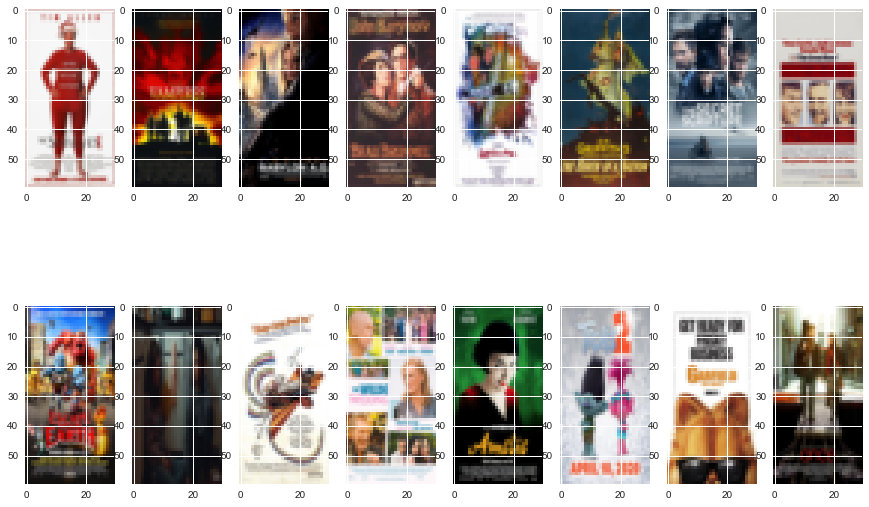

In [25]:
fig, ax = plt.subplots(2, 8, figsize = (15, 10))
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(poster_images[i])

#### test data

In [26]:
poster_images_test = []
for poster_name in tqdm(poster_names[train_size:]):
    poster_id = poster_name.strip('.jpg')
    image = plt.imread('posters/' + poster_name)
    image_resized = misc.imresize(image, (60, 30))
    if image_resized.shape == (60, 30):
        image_resized = np.array([image_resized, image_resized, image_resized]).reshape(60, 30, 3)
    if image_resized.shape == (60, 30, 4):
        image_resized = image_resized[:, :, :3]
    image_resized = image_resized / 255
    poster_images_test.append(image_resized)

  0%|          | 0/2254 [00:00<?, ?it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
  1%|          | 19/2254 [00:03<06:10,  6.03it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (92984898 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 10%|▉         | 215/2254 [00:40<06:23,  5.31it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (98713125 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 11%|█         | 247/2254 [00:48<06:31,  5.13it/s]/Users/jerrysun/anaconda/lib/python3.6/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (

In [27]:
poster_images_test = np.array(poster_images_test)

In [28]:
poster_images_test.shape

(2254, 60, 30, 3)

#### poster visualization

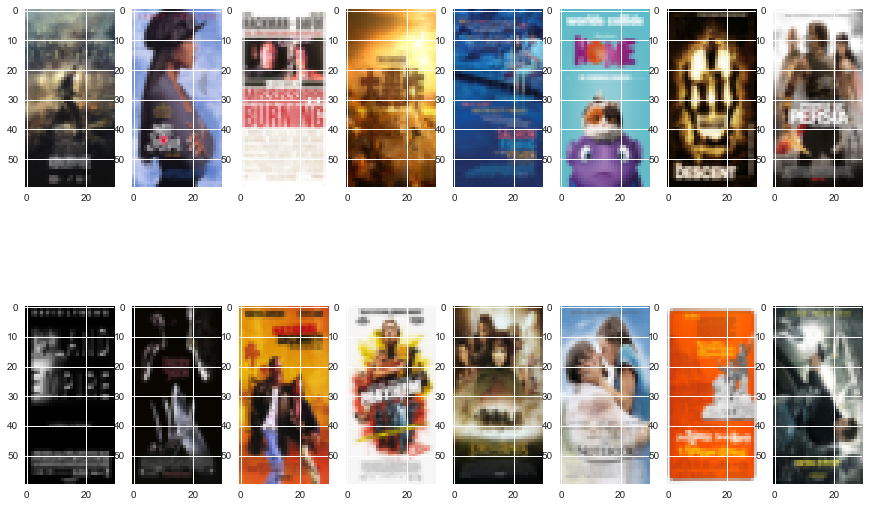

In [29]:
fig, ax = plt.subplots(2, 8, figsize = (15, 10))
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(poster_images_test[i])

In [30]:
poster_images.shape[0] + poster_images_test.shape[0] == len(poster_names)

True

#### prepare the dataset for GPU computing

In [31]:
np.save('poster_train.npy', poster_images)

In [32]:
np.save('poster_test.npy', poster_images_test)

In [33]:
np.save('poster_labels.npy', target_labels)

### GPU Computing

#### read in training data

In [3]:
poster_train = np.load('poster_train.npy')
poster_test = np.load('poster_test.npy')
poster_labels = np.load('poster_labels.npy')

#### sanity check

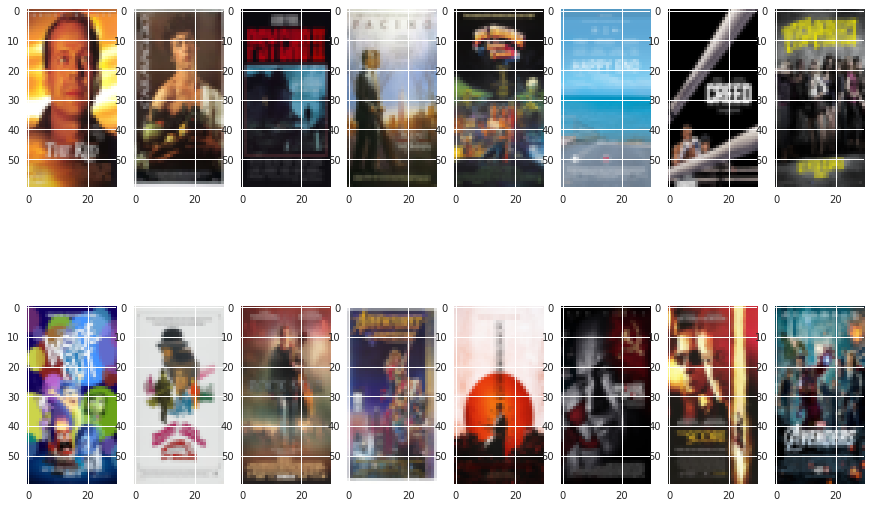

In [4]:
fig, ax = plt.subplots(2, 8, figsize = (15, 10))
ax = ax.flatten()
for i in range(16):
    ax[i].imshow(poster_train[i])

In [5]:
poster_train.shape

(3992, 60, 30, 3)

In [6]:
poster_test.shape

(2251, 60, 30, 3)

In [7]:
poster_labels.shape

(6243, 20)

#### fit the convolutional neural network

In [8]:
ad_train_size = 3992
num_class = 20

In [26]:
cnn = Sequential()
cnn.add(Conv2D(64, (2, 2), input_shape = (60, 30, 3), padding = 'same', activation = 'relu'))
cnn.add(Conv2D(64, (2, 2), padding = 'same', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size= (2,2)))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(128, (2, 2), padding = 'valid', activation = 'relu'))
cnn.add(Conv2D(128, (2, 2), padding = 'valid', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size= (2,2)))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(256, (2, 2), padding = 'valid', activation = 'relu'))
cnn.add(Conv2D(256, (2, 2), padding = 'valid', activation = 'relu'))
cnn.add(MaxPooling2D(pool_size= (2,2)))

cnn.add(Flatten())

cnn.add(Dense(2048, activation = 'relu'))

cnn.add(Dropout(0.3))

cnn.add(Dense(1024, activation = 'relu'))


cnn.add(Dense(num_class, activation = 'sigmoid'))

In [27]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 60, 30, 64)        832       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 30, 64)        16448     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 15, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 15, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 14, 128)       32896     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 13, 128)       65664     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 6, 128)        0         
__________

In [28]:
cnn.compile(optimizer = Adam(lr=0.0005), loss = 'binary_crossentropy', 
            metrics = ['accuracy'])

In [29]:
cnn_history = cnn.fit(poster_train, poster_labels[:ad_train_size], batch_size = 32, epochs = 30, 
              validation_data = (poster_test, poster_labels[ad_train_size:]))

Train on 3992 samples, validate on 2251 samples
Epoch 1/30
3992/3992 [==============================] - 7s 2ms/step - loss: 0.4039 - acc: 0.8432 - val_loss: 0.4117 - val_acc: 0.8466
Epoch 2/30
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3896 - acc: 0.8466 - val_loss: 0.3938 - val_acc: 0.8428
Epoch 3/30
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3890 - acc: 0.8468 - val_loss: 0.3903 - val_acc: 0.8428
Epoch 4/30
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3885 - acc: 0.8473 - val_loss: 0.3916 - val_acc: 0.8466
Epoch 5/30
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3883 - acc: 0.8466 - val_loss: 0.3892 - val_acc: 0.8466
Epoch 6/30
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3879 - acc: 0.8474 - val_loss: 0.3887 - val_acc: 0.8466
Epoch 7/30
3992/3992 [==============================] - 6s 2ms/step - loss: 0.3880 - acc: 0.8474 - val_loss: 0.3888 - val_acc: 0.8466
Epoch 8/30
399

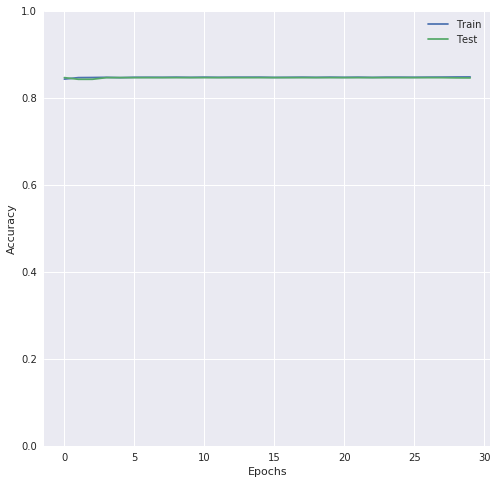

In [36]:
fig, ax = plt.subplots(figsize = (8, 8))
plot_learning_curve(cnn_history, ax)

### Evaluating the Model
We are unable to train a convolutionnal neural network based on the reshaped/compressed posters evidenced by the learning curve.

In [37]:
train_prob = cnn.predict(poster_train)
test_prob = cnn.predict(poster_test)

In [47]:
cnn_metrics = metrics_thres_df(poster_labels[:ad_train_size], poster_labels[ad_train_size:],
                              train_prob, test_prob)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
# evaluation
print('CNN Avg Accuracy on train : {}'.format(score_thres(poster_labels[:ad_train_size], train_prob, method = 'avg')))
print('CNN Exact Accuracy on train : {}'.format(score_thres(poster_labels[:ad_train_size], train_prob, method = 'exact')))
print('CNN Precision on train : {}'.format(score_thres(poster_labels[:ad_train_size], train_prob, method = 'precision')))
print('CNN Recall on train : {}'.format(score_thres(poster_labels[:ad_train_size], train_prob, method = 'recall')))
print('CNN Hit Rate on train : {}'.format(score_thres(poster_labels[:ad_train_size], train_prob, method = 'hit')))
print('CNN F1 score on train : {}'.format(score_thres(poster_labels[:ad_train_size], train_prob, method = 'f1')))

CNN Avg Accuracy on train : 0.8486598196392785
CNN Exact Accuracy on train : 0.031813627254509015
CNN Precision on train : 0.3680646642182581
CNN Recall on train : 0.04988084981823022
CNN Hit Rate on train : 0.5275551102204409
CNN F1 score on train : 0.0878553668967741


/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
# evaluation
print('CNN Avg Accuracy on train : {}'.format(score_thres(poster_labels[ad_train_size:], test_prob, method = 'avg')))
print('CNN Exact Accuracy on train : {}'.format(score_thres(poster_labels[ad_train_size:], test_prob, method = 'exact')))
print('CNN Precision on train : {}'.format(score_thres(poster_labels[ad_train_size:], test_prob, method = 'precision')))
print('CNN Recall on train : {}'.format(score_thres(poster_labels[ad_train_size:], test_prob, method = 'recall')))
print('CNN Hit Rate on train : {}'.format(score_thres(poster_labels[ad_train_size:], test_prob, method = 'hit')))
print('CNN F1 score on train : {}'.format(score_thres(poster_labels[ad_train_size:], test_prob, method = 'f1')))

CNN Avg Accuracy on train : 0.845957352287872
CNN Exact Accuracy on train : 0.02576632607729898
CNN Precision on train : 0.051631433823529416
CNN Recall on train : 0.047921695356666454
CNN Hit Rate on train : 0.5153265215459796
CNN F1 score on train : 0.049707444916985435


/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Plot

In [52]:
score_df = pd.DataFrame({'CNN': cnn_metrics})

In [53]:
score_df

,CNN
Train Avg Accuracy,0.848660
Train Exact Accuracy,0.031814
Train Precision,0.368065
Train Recall,0.049881
Train Hit Rate,0.527555
Train F1 Score,0.087855
Test Avg Accuracy,0.845957
Test Exact Accuracy,0.025766
Test Precision,0.051631
Test Recall,0.047922


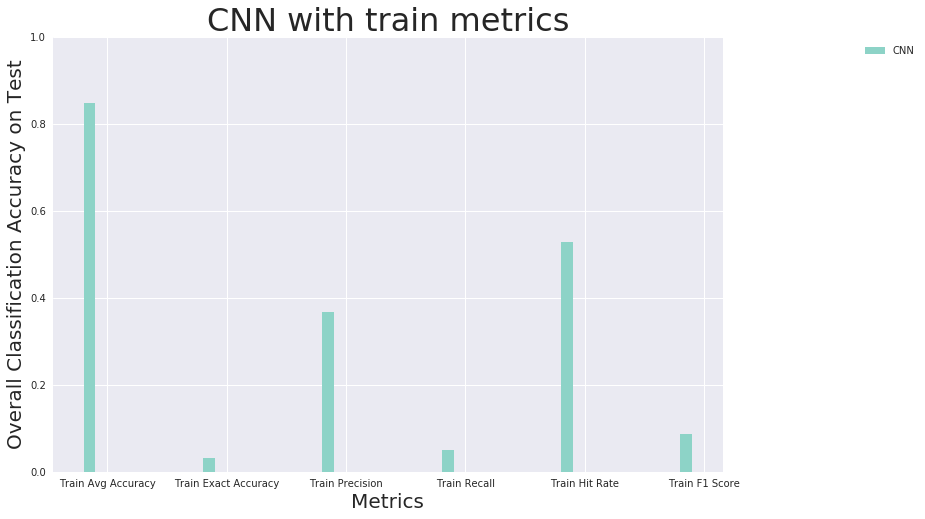

In [59]:
bar_width = 0.1
plt.figure(figsize = (12,8))
for idx,col in enumerate(score_df.columns):
    plt.bar(np.arange(len(score_df.index[:6]))+idx*bar_width, score_df[[col]].values[:6][:,0],
            bar_width, color=sns.color_palette("Set3")[idx], label=col)
plt.xticks(np.arange(len(score_df.index[:6]))+0.15, score_df.index[:6])
plt.ylabel('Overall Classification Accuracy on Test', fontsize = 20)
plt.xlabel('Metrics', fontsize = 20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylim(0,1)
plt.title('CNN with train metrics', fontsize = 32)
plt.show()

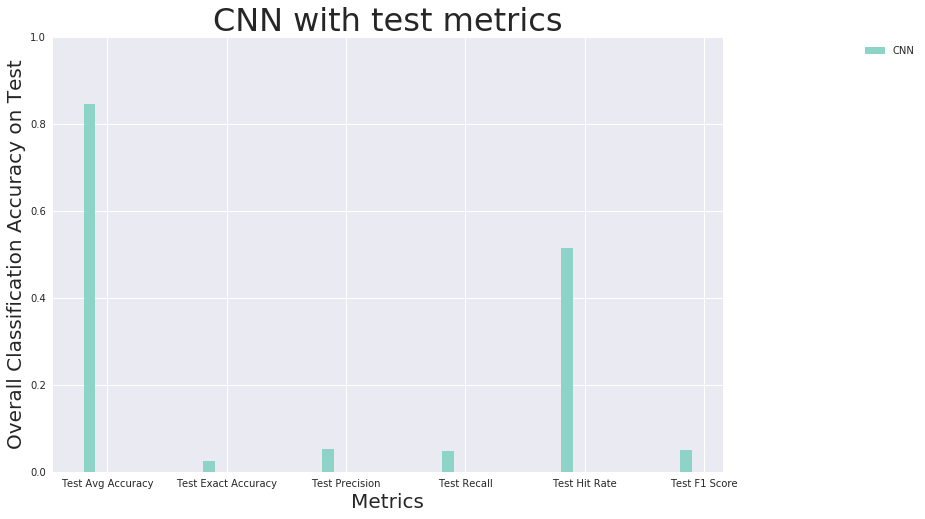

In [67]:
bar_width = 0.1
plt.figure(figsize = (12,8))
for idx,col in enumerate(score_df.columns):
    plt.bar(np.arange(len(score_df.index[6:12]))+idx*bar_width, score_df[[col]].values[6:12][:,0],
            bar_width, color=sns.color_palette("Set3")[idx], label=col)
plt.xticks(np.arange(len(score_df.index[6:12]))+0.15, score_df.index[6:12])
plt.ylabel('Overall Classification Accuracy on Test', fontsize = 20)
plt.xlabel('Metrics', fontsize = 20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.ylim(0,1)
plt.title('CNN with test metrics', fontsize = 32)
plt.show()

We are unable to train a CNN using compressed images to classify the genre.